# CIS IEE - 4° Período (NLP)

## Analise do dataset

In [1]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Lendo o dataframe:
df = pd.read_csv('Musical_instruments_reviews.csv', sep = ",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
print(df.shape)

(10261, 9)


A partir de uma analise inicial do head do dataframe, não parece ter nada de errado com as colunas. Vamos analisar as linhas contidas nele agora para ver se há valores faltando.

In [4]:
#Checando por valores nulos:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Podemos ver que existem alguns valores nulos presentes neles. Vamos trabalhar apenas em cima do reviewText para analisar se a rede é capaz de considerar o review como positivo ou negativo. <br> <br>
A partir disso, vamos pegar apenas os casos em que os reviewTexts não foram nulos.

In [5]:
df['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

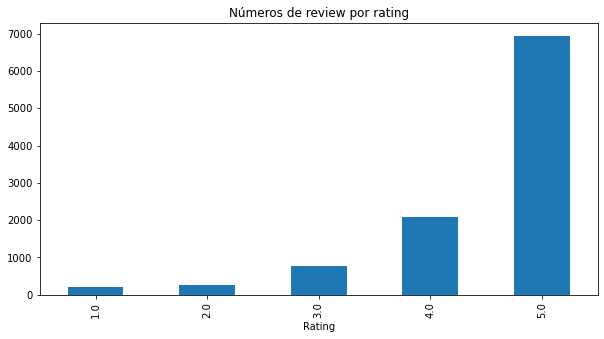

In [6]:
ax = df['overall'].value_counts().sort_index().plot(kind = 'bar', title = 'Números de review por rating', figsize = (10,5))
ax.set_xlabel("Rating")

plt.show()

Podemos ver que a grande maioria de reviews presentes no dataset são positivos.

In [7]:
#Aqui vamos pegar apenas os reviews e suas respectivas notas, tirando os reviews em branco
reviewTextScores = df[['reviewText', 'overall']].dropna()
reviewTextScores.head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0


In [8]:
#Checando por valores nulos:
reviewTextScores.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [9]:
#Analise das dimensoes (10261 - 7 = 10254)
reviewTextScores.shape

(10254, 2)

## Pré-processamento de dados

In [10]:
#Função para pré-processamento dos dados:

def preprocess_text(text):
    
    # Tokenization para pré-processamento
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Remover pontuação
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Conversao de volta para texto
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [11]:
#Visualização antes do pré-processamento

reviewTextScores['reviewText'][0]

"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,"

In [12]:
#Aplicação da função de pré-processamento no nosso novo dataset

reviewTextScores['reviewText'] = reviewTextScores['reviewText'].apply(preprocess_text)

In [13]:
#Visualização após pré-processamento

reviewTextScores['reviewText'][0]

"much write exactly 's supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing"

## Tokenizing text w/ sklearn (BOW + TFIDF)

In [14]:
#Tokenização via BOW
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(reviewTextScores['reviewText'])

#Tokenização via TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(reviewTextScores['reviewText'])

In [15]:
#Visualização tokens BOW parcial

count_vectorizer.get_feature_names()[0:10]

C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '000s', '001', '003', '004', '0045', '007', '008', '008ex']

In [16]:
#Visualização tokens TFIDF parcial

tfidf_vectorizer.get_feature_names()[0:10]

['00', '000', '000s', '001', '003', '004', '0045', '007', '008', '008ex']

## Tokenizer com Tensorflow + padding

In [17]:
#Início da tokenização - setup do vocabulario total + tokenizer

max_vocab_size = 10000  # Número máximo de palavras no vocabulario
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')  # '<OOV>' = "out-of-vocabulary" 

In [18]:
texts = reviewTextScores['reviewText'].tolist()  #Fazer lista de strings para colocar no tokenizer
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) #Transformação do texto em sequências de inteiros
word_index = tokenizer.word_index

In [19]:
sequences[0]

[23,
 1604,
 318,
 4,
 594,
 502,
 434,
 6,
 130,
 23,
 1122,
 5,
 2084,
 18,
 434,
 502,
 180,
 181,
 13,
 50,
 938,
 14,
 1194,
 2927]

In [20]:
texts[0]

"much write exactly 's supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing"

In [21]:
#Checagem rápida se os tokens realmente estão funcionando como deveriam:

phrase = texts[0].split(' ')

for words in phrase:
    
    if words in word_index:
        token = word_index[words]
        print(f"O token de '{words}' é: {token}")
    else:
        print(f"'{words}' não está no vocabulário.")

O token de 'much' é: 23
O token de 'write' é: 1604
O token de 'exactly' é: 318
O token de ''s' é: 4
O token de 'supposed' é: 594
O token de 'filter' é: 502
O token de 'pop' é: 434
O token de 'sound' é: 6
O token de 'recording' é: 130
O token de 'much' é: 23
O token de 'crisp' é: 1122
O token de 'one' é: 5
O token de 'lowest' é: 2084
O token de 'price' é: 18
O token de 'pop' é: 434
O token de 'filter' é: 502
O token de 'amazon' é: 180
O token de 'might' é: 181
O token de 'well' é: 13
O token de 'buy' é: 50
O token de 'honestly' é: 938
O token de 'work' é: 14
O token de 'despite' é: 1194
O token de 'pricing' é: 2927


In [22]:
#Padding para que todas as frases tenham o mesmo tamanho para a rede neural
max_sequence_length = max(map(len, sequences))  #Achar a maior frase
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [23]:
padded_sequences[0]

array([  23, 1604,  318, ...,    0,    0,    0])

In [24]:
padded_sequences.shape

(10254, 1167)

In [25]:
#Para que o modelo funcione:
padded_sequences = np.array(padded_sequences) 

In [26]:
reviewTextScores['overall']

0        5.0
1        5.0
2        5.0
3        5.0
4        5.0
        ... 
10256    5.0
10257    5.0
10258    4.0
10259    4.0
10260    4.0
Name: overall, Length: 10254, dtype: float64

Podemos ver que foi adicionado o padding apropriadamente.

## Modelo usando RNN simples

In [27]:
#Vou considerar que reviews acima de 3 sao positivos e os iguais ou menores que 3 sao negativos.
#Vou fazer dessa forma pois o dataset é muito enviesado para os positivos.
#Assim podemos fazer uma classificacao binaria entre reviews positivos (1) e negativos (0)

reviewTextScores['overall'] = (reviewTextScores['overall'] > 3.0).astype(int)

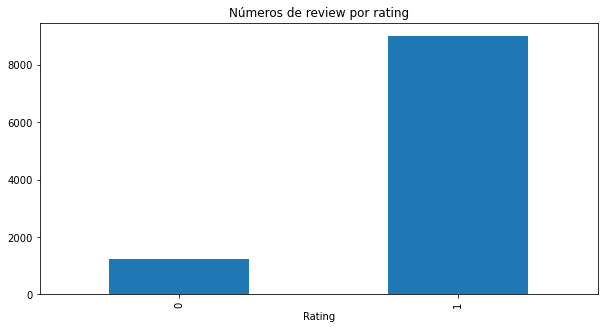

In [28]:
ax = reviewTextScores['overall'].value_counts().sort_index().plot(kind = 'bar', title = 'Números de review por rating', figsize = (10,5))
ax.set_xlabel("Rating")

plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, reviewTextScores['overall'], test_size=0.2, random_state=42)

In [30]:
X_train.shape

(8203, 1167)

In [31]:
y_train.shape

(8203,)

In [32]:
#Implementação do modelo - RNN simples
labels = y_train #Para ver se ele encontra um valor próximo que o review deveria ser
vocab_size = len(tokenizer.word_index) + 1 #+1 para OOV
embedding_dim = 100  
max_sequence_length = padded_sequences.shape[1]  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(units=128),  
    Dense(units=1, activation='sigmoid') 
    
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


batch_size = 64
num_epochs = 10
model.fit(X_train, labels, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1167, 100)         1935200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1964641 (7.49 MB)
Trainable params: 1964641 (7.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
103/103 [==============================] - 64s 613ms/step - loss: 0.3780 - accuracy: 0.8720 - val_loss: 0.3832 - val_accuracy: 0.8720
Epoch 2/10
103/103 [==============================] - 65s 632ms/step - loss: 0.3688 - accuracy: 0.8798 - val_loss: 0.3826 - val_accuracy:

In [33]:
predictions = model.predict(X_test)

predicted_classes = (predictions > 0.5).astype(int)

65/65 [==============================] - 6s 85ms/step


In [34]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")

Accuracy: 0.8829839102876645
Precision: 0.8829839102876645
F1-Score: 0.9378560331434489


In [35]:
#Implementação do modelo - LSTM unidirecional 
labels = y_train #Para ver se ele encontra um valor próximo que o review deveria ser
vocab_size = len(tokenizer.word_index) + 1  
embedding_dim = 100  
max_sequence_length = padded_sequences.shape[1]  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(units=16),
    Dense(units=1, activation='sigmoid') 
    
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


batch_size = 32
num_epochs = 10
model.fit(X_train, labels, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1167, 100)         1935200   
                                                                 
 lstm (LSTM)                 (None, 16)                7488      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1942705 (7.41 MB)
Trainable params: 1942705 (7.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
206/206 [==============================] - 90s 430ms/step - loss: 0.3907 - accuracy: 0.8764 - val_loss: 0.3829 - val_accuracy: 0.8720
Epoch 2/10
206/206 [==============================] - 86s 420ms/step - loss: 0.3679 - accuracy: 0.8798 - val_loss: 0.3827 - val_accurac

In [36]:
predictions = model.predict(X_test)

predicted_classes = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")

65/65 [==============================] - 6s 90ms/step
Accuracy: 0.8829839102876645
Precision: 0.8829839102876645
F1-Score: 0.9378560331434489


In [37]:
#Implementação do modelo - LSTM bidirecional 
labels = y_train #Para ver se ele encontra um valor próximo que o review deveria ser
vocab_size = len(tokenizer.word_index) + 1  
embedding_dim = 100  
max_sequence_length = padded_sequences.shape[1]  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=16)),
    Dense(units=1, activation='sigmoid') 
    
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


batch_size = 32
num_epochs = 10
model.fit(X_train, labels, batch_size=batch_size, epochs=num_epochs, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1167, 100)         1935200   
                                                                 
 bidirectional (Bidirection  (None, 32)                14976     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1950209 (7.44 MB)
Trainable params: 1950209 (7.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
206/206 [==============================] - 128s 606ms/step - loss: 0.3771 - accuracy: 0.8744 - val_loss: 0.3413 - val_accuracy: 0.8720
Epoch 2/10
206/206 [==============================] - 123s 598ms/ste

In [38]:
predictions = model.predict(X_test)

predicted_classes = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")

65/65 [==============================] - 9s 133ms/step
Accuracy: 0.8649439297903462
Precision: 0.8965873836608066
F1-Score: 0.9260347129506008
